In [1]:
### This notebook pulls interesting parameters from waterfall plots that are not
### natively covered by turboSETI (and so not found in .dat files).

### The intention is for the whole notebook to be run at once, e.g. in a screen 
### or tmux window, since there's a lot of blimpy-calling and waterfall-compressing.

import bldw
import glob
import numpy as np
import blimpy as bl
import matplotlib.pyplot as plt
import setigen
import pandas as pd
import pickle
from scipy.stats import skew, kurtosis, norm
from scipy import stats
from scipy.interpolate import interp1d
%matplotlib inline


In [2]:
# define files

lfiles = ['/datag/pipeline/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.h5',
'/datag/pipeline/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_16530_HIP2792_0058.gpuspec.0000.h5',
'/datag/pipeline/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_16851_MESSIER031_0059.gpuspec.0000.h5',
'/datag/pipeline/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_17168_HIP3077_0060.gpuspec.0000.h5',
'/datag/pipeline/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_17485_MESSIER031_0061.gpuspec.0000.h5',
'/datag/pipeline/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_17801_HIP3223_0062.gpuspec.0000.h5']

In [8]:
### REWRITING PARAMETER_PULLING.IPYNB SCRIPT TO READ ARRAY INTO MEMORY AT BEGINNING

# pull spectral kurtosis, skewness, Sarle's coefficient, correlation of kurtosis-log(bandwidth)

fb = bl.Waterfall(lfiles[0]) # only first ON pointing for now

caleb_wl = 0.002700    # 2.7 kHz, from Caleb Painter's work

freqs, full_dynamic_spectrum = fb.grab_data() # grab data around hit

print(f'Full dynamic spectrum shape is {np.shape(full_dynamic_spectrum)}.')

filename = '/datax/scratch/benjb/m31_l_data/' + lfiles[0][44:-2] + 'dat'

df = pd.read_table(filename, sep='\s+', names=['Top_Hit_#','Drift_Rate','SNR','Uncorrected_Frequency','Corrected_Frequency',
                                            'Index', 'freq_start', 'freq_end', 'SEFD', 'SEFD_freq', 'Coarse_Channel_Number', 
                                            'Full_number_of_hits'], skiprows=9)

ctr_freqs = df['Uncorrected_Frequency'].values
start_freqs = df['freq_start'].values
end_freqs = df['freq_end'].values

drifts = df['Drift_Rate'].values
snrs = df['SNR'].values

kurts = []
skews = []
sarles = []
tbws = []
corrs = []

for ii, freq in enumerate(ctr_freqs):

    print(f'Beginning analysis of hit at frequency {freq} MHz ...')

    dynamic_spectrum = full_dynamic_spectrum[:,np.where((freqs < freq+caleb_wl/2) & (freqs > freq-caleb_wl/2))[0]]
    print(np.shape(dynamic_spectrum)) # check to make sure we've sliced along the correct axis

    #freqs, dynamic_spectrum = fb.grab_data(f_start=freq-caleb_wl/2, f_stop=freq+caleb_wl/2) # grab data around hit
    power_spectrum = np.average(dynamic_spectrum, axis=0)
    power_spectrum = (power_spectrum-np.median(power_spectrum)) # subtract
    power_spectrum = power_spectrum / power_spectrum.max()      # and divide

    ku = kurtosis(power_spectrum, fisher=False)  # Pearson (not Fisher) for Sarle calculation
    sk = skew(power_spectrum)
    sarle = (sk**2 + 1) / ku           # Sarle's bimodality coefficient
                                       # = 5/9 for uniform, larger possibly suggests multimodality

    print(f'Hit number {ii} of {len(ctr_freqs)}:')
    print(f'    Spectral kurtosis is {ku}.')
    print(f'    Spectral skewness is {sk}.')
    print(f'    Sarle\'s coefficient is {sarle}.')

    kurts.append(ku)
    skews.append(sk)
    sarles.append(sarle)

    window_lengths = np.logspace(np.log10(0.0002), np.log10(0.1000), 50)
    mini_kurts = []

    for wl in window_lengths:
        dynamic_spectrum = full_dynamic_spectrum[:,np.where((freqs < freq+wl/2) & (freqs > freq-wl/2))[0]]
        power_spectrum = np.average(dynamic_spectrum, axis=0)
        power_spectrum = power_spectrum / power_spectrum.max()
        mk = kurtosis(power_spectrum, fisher=False)
        print(f'Spectral kurtosis is {mk} for bandwidth {round(1e6*wl)} Hz.')
        mini_kurts.append(mk)

    turning_bandwidth = window_lengths[np.argmax(mini_kurts)]
    tbws.append(turning_bandwidth)

    subset_kurtoses = np.array(mini_kurts)[np.where(window_lengths <= caleb_wl)[0]]
    subset_windows = window_lengths[np.where(window_lengths <= caleb_wl)[0]]

    correlation_coefficient = stats.pearsonr(np.log10(subset_windows), subset_kurtoses)[0]
    corrs.append(correlation_coefficient)

    print(f'    Maximum kurtosis occurs at bandwidth {turning_bandwidth}.')
    print(f'    Correlation coefficient is {correlation_coefficient}.')

    #plt.scatter(np.array(window_lengths)*1000000, mini_kurts)
    #plt.xlabel('window bandwidth [Hz]')
    #plt.ylabel('Pearson kurtosis')
    #plt.xscale('log')
    #plt.show()

    #break

kurts = np.array(kurts)
skews = np.array(skews)
sarles = np.array(sarles)
tbws = np.array(tbws)
corrs = np.array(corrs)

#np.savez('/datax/scratch/benjb/kurtoses.npz', kurts)
#np.savez('/datax/scratch/benjb/skewnesses.npz', skews)
#np.savez('/datax/scratch/benjb/sarles.npz', sarles)
np.savez('/datax/scratch/benjb/new_tbws.npz', tbws)  # turning bandwidths [MHz]
np.savez('/datax/scratch/benjb/new_corrs.npz', corrs) # Pearson correlation coefficients

print('Done!')

Full dynamic spectrum shape is (16, 67108864).
Beginning analysis of hit at frequency 1681.553703 MHz ...
(16, 967)
Hit number 0 of 3068:
    Spectral kurtosis is 129.90566694905488.
    Spectral skewness is 8.573882102966309.
    Sarle's coefficient is 0.5735812460343792.
Spectral kurtosis is 24.861668600934625 for bandwidth 200 Hz.
Spectral kurtosis is 28.27664309580047 for bandwidth 227 Hz.
Spectral kurtosis is 32.439159685470834 for bandwidth 258 Hz.
Spectral kurtosis is 36.488279531066524 for bandwidth 293 Hz.
Spectral kurtosis is 40.90312637798612 for bandwidth 332 Hz.
Spectral kurtosis is 45.74006165711838 for bandwidth 377 Hz.
Spectral kurtosis is 51.19874820581167 for bandwidth 428 Hz.
Spectral kurtosis is 56.31699843288086 for bandwidth 486 Hz.
Spectral kurtosis is 62.51168785045046 for bandwidth 552 Hz.
Spectral kurtosis is 68.87188748783467 for bandwidth 626 Hz.
Spectral kurtosis is 75.41467347543754 for bandwidth 711 Hz.
Spectral kurtosis is 82.76943695318113 for bandwidth

KeyboardInterrupt: 

0.9885255287143138
[125.60593675 126.08929144 126.24709836 126.07935751 125.58606889
 124.7672325 ]


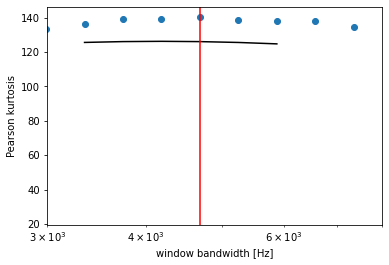

In [49]:
""" subset_kurtoses = np.array(mini_kurts)[np.where(window_lengths <= 0.002700)[0]]
subset_windows = window_lengths[np.where(window_lengths <= 0.002700)[0]]

print(stats.pearsonr(np.log10(subset_windows), subset_kurtoses)[0])

z = np.polyfit(np.log10(1e6 * window_lengths), mini_kurts, 2)
p = np.poly1d(z)
x_new = 1e6*window_lengths[np.argmax(mini_kurts)-3 : np.argmax(mini_kurts)+3]
y_new = p(np.log10(x_new))
print(p(np.log10(x_new)))

plt.scatter(np.array(window_lengths)*1000000, mini_kurts)
plt.scatter(subset_windows*1000000, subset_kurtoses)
plt.plot(x_new, y_new, color='k')
plt.axvline(2700, color='k')
plt.axvline(1e6*np.array(window_lengths)[np.argmax(mini_kurts)], color='r')
plt.xlabel('window bandwidth [Hz]')
plt.ylabel('Pearson kurtosis')
plt.xscale('log')
plt.xlim(3000, 8000)
plt.show() """